# Introduction to Image Segmentation

`Image segmentation` is the process of partitioning an image into multiple
segments. The goal of segmentation is to simplify and/or change the 
representation of an image into something that is more meaningful and 
easier to analyze. Image segmentation is typically used to locate objects 
and boundaries (lines, curves, etc.) in images. More precisely, image 
segmentation is the process of assigning a label to every pixel in an 
image such that pixels with the same label share certain characteristics.

**Image Segmentation Algorithms**

- `GrabCut Algorithm`: The GrabCut algorithm is an iterative algorithm 
used for foreground and background segmentation. The algorithm requires
the user to specify a rectangle around the object to be segmented. The
algorithm then iteratively refines the segmentation by updating the
Gaussian Mixture Model (GMM) parameters and the segmentation mask.

- `Watershed Segmentation`: This technique is used to segment an
image into different regions. The regions are created based on the
topographical surface of the image. The image is considered as a
topographical surface where light pixels represent peaks and dark
pixels represent valleys. The water is poured into the valleys and
the regions are formed when the water from different valleys meet.

# Setup

In [ ]:
%pip install opencv-python opencv-contrib-python matplotlib

# Initial Setup

In [1]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Asset Root
asset_root = os.path.join(os.getcwd(), '../../assets')

# GrabCut Algorithm

`GrabCut` is an image segmentation method based on graph cuts. It was 
created by Carsten Rother, Vladimir Kolmogorov, and Andrew Blake from 
Microsoft Research Cambridge, UK. The algorithm is based on the paper: 
"GrabCut": interactive foreground extraction using iterated graph cuts.
The algorithm works using the following steps:

1. A rectangle including the subject(s) of the picture is defined.

2. The area lying outside the rectangle is automatically defined as
a background.

3. The data contained in the background is used as a reference to
distinguish background areas from foreground areas within the
user-defined rectangle

4. Use the Gaussian Mixture Model (GMM) to model the foreground and 
background, and assign each pixel to either the foreground or background.
Undefined pixels are labeled as probable foreground or probable
background.

5. Each pixel in the image is virtually connected to the surrounding
pixels through virtual edges, and each edge is assigned a probability of 
being foreground or background, based on how similar it is in color to 
the pixels surrounding it.

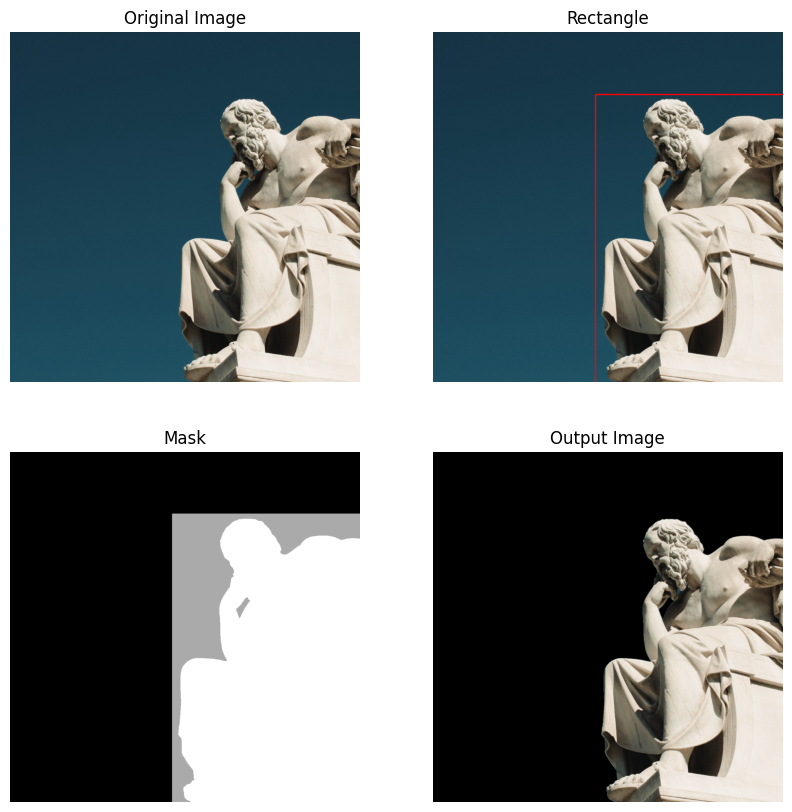

In [2]:
# Image Path
image_path = os.path.join(asset_root, 'images', 'greek_statue_02.png')

# Read Image and convert to RGB
input_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Define the rectangle for the subject
rectangle = (500, 190, 1080, 1080)

# Create a mask of zeros with the same shape as the input image
mask = np.zeros(input_image.shape[:2], np.uint8)

# Create a mask of zeros with the same shape as the input image
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Apply GrabCut Algorithm
cv2.grabCut(input_image, mask, rectangle, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Create a mask with the foreground and probable foreground
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Apply the mask to th original image
output_image = input_image * mask2[:, :, np.newaxis]

# Display All Images
plt.figure("GraphCut Image Segmentation", figsize=(10, 10))

# Display Original Image
plt.subplot(2, 2, 1)
plt.imshow(input_image)
plt.title("Original Image")
plt.axis('off')

# Draw the Rectangle on the Original Image
plt.subplot(2, 2, 2)
plt.imshow(input_image)
plt.title("Rectangle")
plt.axis('off')
plt.gca().add_patch(plt.Rectangle((rectangle[0], rectangle[1]), rectangle[2], rectangle[3], edgecolor='r', facecolor='none'))

# Display the Mask
plt.subplot(2, 2, 3)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

# Display the Output Image
plt.subplot(2, 2, 4)
plt.imshow(output_image)
plt.title("Output Image")
plt.axis('off')

plt.show()

The code above uses the `cv2.grabCut` function to apply the GrabCut
algorithm to the input image. The function takes the following parameters:

1. `img`: The input image.

2. `mask`: A mask image of the same size as the input image. The mask
is initialized with zeros and is used to mark the pixels as background,
foreground, probable background, and probable foreground.

3. `rect`: A rectangle that includes the subject(s) of the image.

4. `bgdModel`: An array that contains the background model.

5. `fgdModel`: An array that contains the foreground model.

6. `iterCount`: The number of iterations the algorithm will run.

7. `mode`: The mode of operation. The `cv2.GC_INIT_WITH_RECT` mode
initializes the mask using the rectangle.

# Watershed Algorithm

`Watershed` is an image segmentation algorithm based on the concept of
watershed lines. The algorithm is called Watershed because its
conceptualization involves water. Imagine areas with low density
(little to no change) in an image as valleys, and areas with high density
(lots of change) as peaks. Start filling the valleys with water to the 
point where water from two different valleys is about to merge. To 
prevent the merging of water from different valleys, you build a barrier 
to keep them separated. The resulting barrier is the image segmentation.
The algorithm works using the following steps:

1. Convert the image to grayscale.

2. Apply a threshold to the image to create a binary image.

3. Apply morphological operations to remove noise and fill holes
in the image to get the sure background.

4. Apply the distance transform to the binary image to know 
the sure foreground.

5. For regions in between the sure background and sure foreground,
subtract the sure background from the sure foreground to get the
unknown region.

6. Find the markers for the unknown region. The markers are the
barricades that will separate the different regions.

7. Add 1 to the labels for all regions because we only want unknowns to
stay at 0.

8. Apply the watershed algorithm to the image.

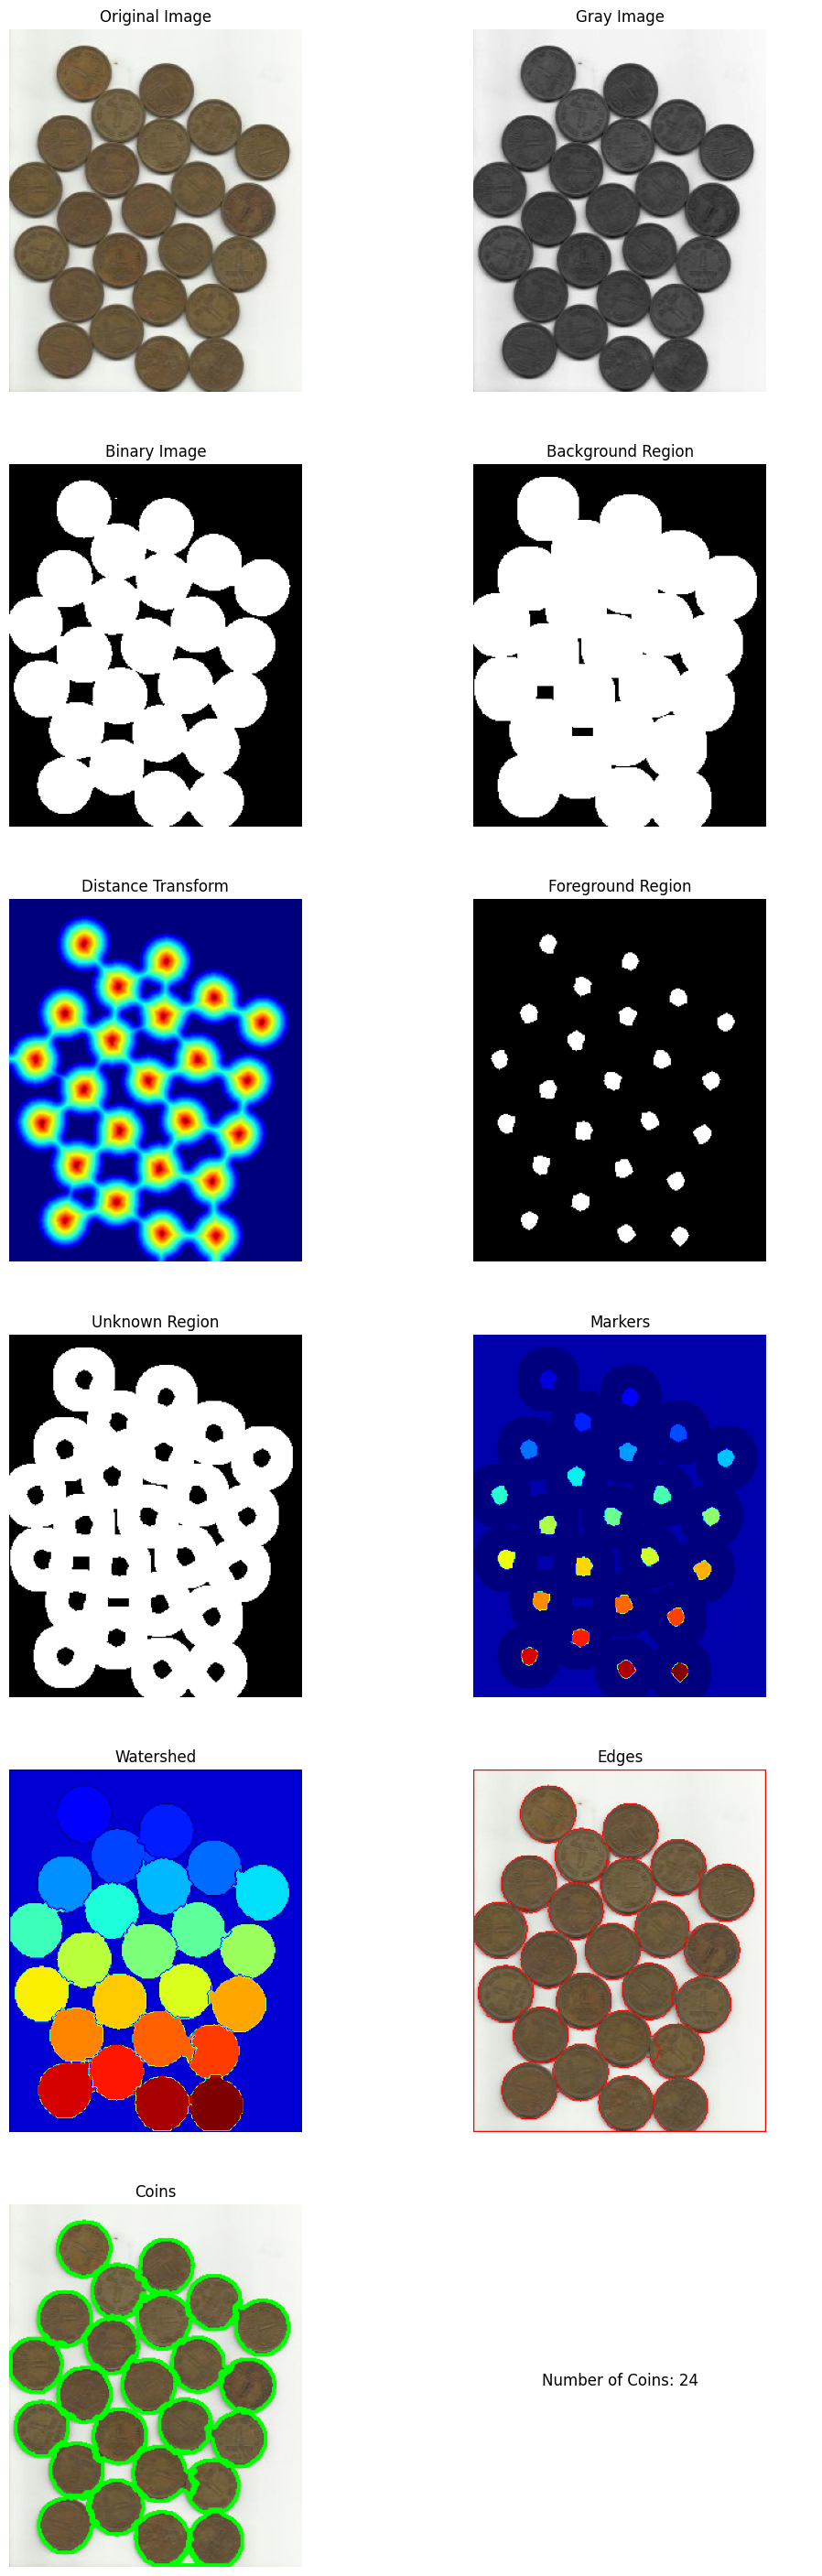

In [7]:
# Image Path
image_path = os.path.join(asset_root, 'images', 'coins.jpg')

# Read Image and convert to RGB
input_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)

# Apply a threshold to the image
_, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Apply morphological operations to remove noise and fill holes
kernel = np.ones((3, 3), np.uint8)

opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=2)

# Find the sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Apply distance transform to the binary image
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Find the sure foreground
sure_fg = np.uint8(sure_fg)

# Find the unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Label the sure foreground to find the barriers or markers
_, markers = cv2.connectedComponents(sure_fg)

# Add 1 to the labels for all regions
markers = markers + 1

# Label the unknown region as 0
markers[unknown == 255] = 0

markers_copy = markers.copy()

# Apply the watershed algorithm
watershed = cv2.watershed(input_image, markers)

# Color the edges of the markers
edges = input_image.copy()
edges[watershed == -1] = [255, 0, 0]

# Find the number of coins
labels = np.unique(watershed)

coins = []
for label in labels:
    if label == -1:
        continue

    target = np.where(watershed == label, 255, 0).astype(np.uint8)
    
    contours, _ = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    coins.append(contours[0])
    
# Draw the contours on the image and add counter
coins_image = cv2.drawContours(input_image.copy(), coins, -1, color=(0, 255, 0), thickness=2)

# Display All Images
plt.figure("Watershed Image Segmentation", figsize=(12, 36))

# Display Original Image
plt.subplot(6, 2, 1)
plt.imshow(input_image)
plt.title("Original Image")
plt.axis('off')

# Display Gray Image
plt.subplot(6, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title("Gray Image")
plt.axis('off')

# Display Binary Image
plt.subplot(6, 2, 3)
plt.imshow(binary_image, cmap='gray')
plt.title("Binary Image")
plt.axis('off')

# Display Sure Background
plt.subplot(6, 2, 4)
plt.imshow(sure_bg, cmap='gray')
plt.title("Background Region")
plt.axis('off')

# Display Distance Transform
plt.subplot(6, 2, 5)
plt.imshow(dist_transform, cmap='jet')
plt.title("Distance Transform")
plt.axis('off')

# Display Sure Foreground
plt.subplot(6, 2, 6)
plt.imshow(sure_fg, cmap='gray')
plt.title("Foreground Region")
plt.axis('off')

# Display Unknown Region
plt.subplot(6, 2, 7)
plt.imshow(unknown, cmap='gray')
plt.title("Unknown Region")
plt.axis('off')

# Display Markers
plt.subplot(6, 2, 8)
plt.imshow(markers_copy, cmap='jet')
plt.title("Markers")
plt.axis('off')

# Display Watershed
plt.subplot(6, 2, 9)
plt.imshow(watershed, cmap='jet')
plt.title("Watershed")
plt.axis('off')

# Display Edges
plt.subplot(6, 2, 10)
plt.imshow(edges)
plt.title("Edges")
plt.axis('off')

# Display Coins
plt.subplot(6, 2, 11)
plt.imshow(coins_image)
plt.title("Coins")
plt.axis('off')

# Display Number of Coins
plt.subplot(6, 2, 12)
plt.text(0.5, 0.5, f"Number of Coins: {len(coins) - 1}", fontsize=12, ha='center')
plt.axis('off')

plt.show()

The code above uses the `cv2.watershed` function to apply the Watershed
algorithm to the input image. The function takes the following parameters:

1. `image`: The input image.

2. `markers`: The markers for the unknown region. The markers are the
barricades that will separate the different regions.

The function returns an image with the same shape as the input image,
where the regions are labeled with different colors. The regions are
separated by the watershed lines, which are marked with -1.

# Summary

- `Image Segmentation` is the process of dividing an image into multiple
segments or regions based on certain characteristics.

- `GrabCut` is an image segmentation method based on graph cuts. It
works by defining a rectangle that includes the subject(s) of the image
and automatically defining the background area outside the rectangle.
The algorithm uses the Gaussian Mixture Model (GMM) to model the
foreground and background and assigns each pixel to either the
foreground or background.

- `Watershed` is an image segmentation algorithm based on the concept of
watershed lines. The algorithm works by converting the image to grayscale,
applying a threshold to create a binary image, applying morphological
operations to remove noise and fill holes, applying the distance transform
to know the sure foreground, finding the markers for the unknown region,
and applying the watershed algorithm to the image.

# References

- Thomas G. (2022). Graphic Designing: A Step-by-Step Guide (Advanced). Larsen & Keller. ISBN: 978-1-64172-536-1
- Singh M. (2022). Computer Graphics and Multimedia. Random Publications LLP. ISBN: 978-93-93884-95-4
- Singh M. (2022). Computer Graphics Science. Random Publications LLP. ISBN: 978-93-93884-03-9
- Singh M. (2022). Computer Graphics Software. Random Publications LLP. ISBN: 9789393884114
- Tyagi, V. (2021). Understanding Digital Image Processing. CRC Press.
- Ikeuchi, K. (Ed.). (2021). Computer Vision: A Reference Guide (2nd ed.). Springer.
- Bhuyan, M. K. (2020). Computer Vision and Image Processing. CRC Press.
- Howse, J., & Minichino, J. (2020). Learning OpenCV 4 Computer Vision with Python 3: Get to grips with tools, techniques, and algorithms for computer vision and machine learning. Packt Publishing Ltd.
- Kinser, J. M. (2019). Image Operators: Image Processing in Python. CRC Press.
